In [1]:
import os
import IPython.display as ipd
import numpy as np
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
# 
from pathlib import Path
import pandas as pd

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# Path to dataset: structured as /dataset/{genre}/*.wav
DATASET_PATH = Path("data/ELECTRONIC_MUSIC_V2")
GENRES = ["Techno", "House"]

In [3]:
# Storage
filepaths = []
durations = []
sr_list = []
genre_list = []

# Basic Stats: Duration, Sampling Rate
for genre in GENRES:
    genre_path = DATASET_PATH / genre
    for audio_file in genre_path.glob("*.wav"):
        try:
            y, sr = librosa.load(audio_file, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            filepaths.append(audio_file)
            durations.append(duration)
            sr_list.append(sr)
            genre_list.append(genre)
        except Exception as e:
            print(f"Failed to load {audio_file}: {e}")

# Create DataFrame
electronic_tracks_df = pd.DataFrame({
    "filepath": filepaths,
    "genre": genre_list,
    "duration_sec": durations,
    "sampling_rate": sr_list
})

electronic_tracks_df.head()

,filepath,genre,duration_sec,sampling_rate
0,data/ELECTRONIC_MUSIC_V2/Techno/Electronic mus...,Techno,10.0,16000
1,"data/ELECTRONIC_MUSIC_V2/Techno/Music, Techno_...",Techno,10.0,16000
2,"data/ELECTRONIC_MUSIC_V2/Techno/Music, Techno,...",Techno,10.0,16000
3,data/ELECTRONIC_MUSIC_V2/Techno/Electronic mus...,Techno,10.0,16000
4,"data/ELECTRONIC_MUSIC_V2/Techno/Music, Techno_...",Techno,10.0,16000


In [4]:
electronic_tracks_df.iloc[:, 1:].value_counts()

genre   duration_sec  sampling_rate
House   10.0          16000            39
Techno  10.0          16000            29
Name: count, dtype: int64

In [5]:
FRAME_LENGTH = 4096
HOP_LENGTH = FRAME_LENGTH // 4

FRAME_LENGTH, HOP_LENGTH

(4096, 1024)

In [6]:
from utils import extract_features_v2

In [22]:
feature_flags = {
    "zcr": False,
    "centroid": False,
    "onset_strength": False,
    "mfcc": True,
    "chroma": False,
    "spectral_bandwidth": False,
    "spectral_rolloff": False,
    "rms": False,
    "tempogram": False,
    "spectral_contrast": False,
    "tonnetz": False,
    "mel_spectrogram": False,
    "tempogram": False
}

In [23]:
X = []
y = []

for fp, label in zip(electronic_tracks_df["filepath"], electronic_tracks_df["genre"]):
    try:
        audio, sr = librosa.load(fp, sr=None)
        _x = extract_features_v2(filepath=fp, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, segment_duration=10, selected_features=feature_flags)
        
        X.append(_x)
        y.append(label)
        # y.append(label)
    except Exception as e:
        print(f"Failed on {fp}: {e}")

X_segments = np.stack(X)  # shape: (samples, time_steps, features)
y_segments = np.array(y)  # shape: (samples,)

X_segments.shape, y_segments.shape

((68, 1, 157, 13), (68,))

### Treat each segment as an input instance

In [24]:
X = X_segments.reshape(-1, X_segments.shape[2], X_segments.shape[3]).astype(np.float32)
X.shape, X.dtype

((68, 157, 13), dtype('float32'))

### Encode Labels

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_segments)  # 'house', 'techno', 'trance' → 0, 1, 2

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=SEED
)

In [27]:
from sklearn.preprocessing import StandardScaler

def scale_3d_features(X, scaler=None):
    samples, frames, features = X.shape
    
    # Reshape to 2D: combine samples and frames
    X_reshaped = X.reshape(-1, features)  # (samples*frames, features)

    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(X_reshaped)
    
    X_scaled = scaler.transform(X_reshaped)
    
    # Reshape back to 3D
    X_scaled = X_scaled.reshape(samples, frames, features)
    return X_scaled, scaler

In [28]:
X_train_scaled, fitted_scaler = scale_3d_features(X_train)
X_test_scaled, _ = scale_3d_features(X_test, fitted_scaler)

In [29]:
from tensorflow.keras import layers, models

def build_temporal_model(input_shape, num_classes):
    """
    input_shape: (frames, features)
    num_classes: number of output classes
    """
    inputs = layers.Input(shape=input_shape)  # (frames, features)

    # Add Conv1D layers to learn local temporal features across time frames
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Use a Bi-LSTM to capture sequential dependencies
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [36]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (frames, features)
num_classes = len(np.unique(y_train))

model = build_temporal_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=7, batch_size=8)

Epoch 1/7
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.4276 - loss: 0.8114 - val_accuracy: 0.6364 - val_loss: 0.6701
Epoch 2/7
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7806 - loss: 0.5365 - val_accuracy: 0.6364 - val_loss: 0.6442
Epoch 3/7
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7913 - loss: 0.4291 - val_accuracy: 0.6364 - val_loss: 0.6511
Epoch 4/7
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7082 - loss: 0.6086 - val_accuracy: 0.7273 - val_loss: 0.6403
Epoch 5/7
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8834 - loss: 0.3270 - val_accuracy: 0.7273 - val_loss: 0.6184
Epoch 6/7
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8775 - loss: 0.2680 - val_accuracy: 0.7273 - val_loss: 0.5972
Epoch 7/7
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9704 - loss: 0.1785 - val_accuracy: 0.7273 - val_loss: 0.5822


In [37]:
train_acc_values = history.history["accuracy"]
val_acc_values = history.history["val_accuracy"]
loss_values = history.history["loss"]

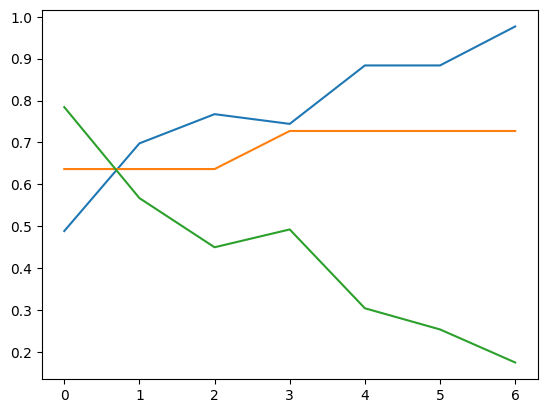

In [38]:
plt.plot(np.arange(len(train_acc_values)), train_acc_values)
plt.plot(np.arange(len(train_acc_values)), val_acc_values)
plt.plot(np.arange(len(train_acc_values)), loss_values)
plt.show()

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.88      0.70         8
           1       0.50      0.17      0.25         6

    accuracy                           0.57        14
   macro avg       0.54      0.52      0.47        14
weighted avg       0.55      0.57      0.51        14



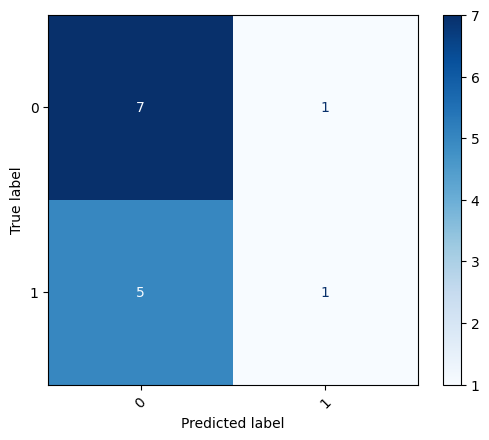

In [40]:
predictions = model.predict(X_test_scaled).argmax(axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, predictions))

# Confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)

In [41]:
def build_2d_spectrogram_model(input_shape, num_classes):
    """
    input_shape: (time, frequency, channels) 
    For example, (frames, n_mel_bands, 1)
    """
    inputs = layers.Input(shape=input_shape)  # e.g. (time, freq, 1)

    x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [42]:
model = build_2d_spectrogram_model((input_shape[0], input_shape[1], 1), num_classes)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(np.expand_dims(X_train_scaled, axis=-1), y_train, validation_split=0.2, epochs=15, batch_size=8)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - accuracy: 0.5603 - loss: 1.3868 - val_accuracy: 0.6364 - val_loss: 0.6528
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8215 - loss: 0.6097 - val_accuracy: 0.6364 - val_loss: 0.6711
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5895 - loss: 0.8883 - val_accuracy: 0.6364 - val_loss: 0.6413
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6216 - loss: 0.9158 - val_accuracy: 0.6364 - val_loss: 0.6436
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8409 - loss: 0.3459 - val_accuracy: 0.6364 - val_loss: 0.6489
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7282 - loss: 0.6451 - val_accuracy: 0.7273 - val_loss: 0.6635
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8199 - loss: 0.3688 - val_accuracy: 0.5455 - val_loss: 0.6891
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8035 - loss: 0.3605 - val_accuracy: 0.2727 - val_loss: 0.7176

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.50      0.83      0.62         6

    accuracy                           0.57        14
   macro avg       0.62      0.60      0.56        14
weighted avg       0.64      0.57      0.55        14



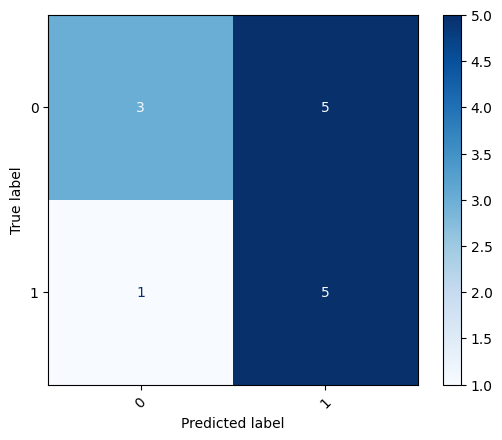

In [43]:
predictions = model.predict(X_test_scaled).argmax(axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, predictions))

# Confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)